# Seismic Image Classification with Convolutional Neural Networks

## 1. Software and Environment Setup

### 1.1 Install some packages

In [1]:
!pip install livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
!pip install pycm

In [3]:
!pip install torch

In [4]:
!pip install obspy

In [5]:
!pip install torchvision

### 1.2 Check the folder containing our data.

In [87]:
import os
fileList = os.listdir('/home/chen/Downloads/Data_1106') # Data folder

In [88]:
print(fileList) # Check the folder

['Inline_3223_DSMF.sgy', 'Xline_1543_class.sgy', 'Inline_3473_class.sgy', 'Xline_1693_class.sgy', 'Xline_1493_class.sgy', 'Inline_3373_class.sgy', 'Inline_3223_class.sgy', 'Inline_3373_DSMF.sgy', 'Inline_3473_DSMF.sgy', 'Xline_1493_DSMF.sgy', 'Xline_1693_DSMF.sgy', 'Xline_1543_DSMF.sgy', 'Inline_3223_DSMF_2.sgy', 'Xline_1693_DSMF_2.sgy', 'Xline_1543_DSMF_2.sgy', 'Xline_1493_DSMF_2.sgy', 'Inline_3373_DSMF_2.sgy', 'Inline_3473_DSMF_2.sgy']


### 1.3 Import functions from the packages.

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    
    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print('Running on GPU')
    device = 'cuda'
else:
    print('Running on CPU')

Running on CPU


Set a bigger limit for open files to avoid a Fatal Error.

In [3]:
torch.multiprocessing.set_sharing_strategy('file_system')
import resource
rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (2048, rlimit[1]))

## 2. Data Preparation

### 2.1 Read and Display the SEGY data

In [4]:
from obspy.io.segy.segy import _read_segy

stream = _read_segy('/home/chen/Downloads/Data_1106/Inline_3473_DSMF_2.sgy', headonly=True) # read a inline as an example

In [110]:
stream

1101 traces in the SEG Y structure.

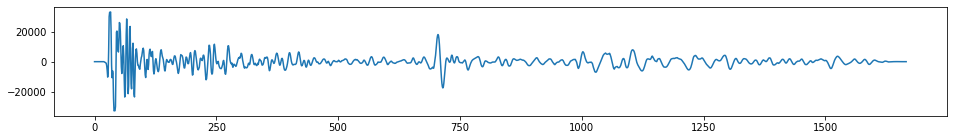

In [111]:
one_trace = stream.traces[0] # The first trace

plt.figure(figsize=(16,2))
plt.plot(one_trace.data) # Plot the first trace
plt.show()

In [112]:
stream.traces[0].data.shape # Check the seismic dimensions

(1667,)

We need to transpose the original SEGY traces to make it same as the seismic image we meet everyday.

In [113]:
fig1 = []
for i in range(len(stream.traces)):
    fig1.append(stream.traces[i].data)
fig1 = np.array(fig1)
fig1 = fig1.T
print(fig1.shape) # Check the seismic dimensions

(1667, 1101)


In [114]:
vm = np.percentile(fig1, 99) # Show with 99th percentile of the amplitude
print("The 99th percentile is {:.0f}; the max amplitude is {:.0f}".format(vm, fig1.max()))

The 99th percentile is 11083; the max amplitude is 35259


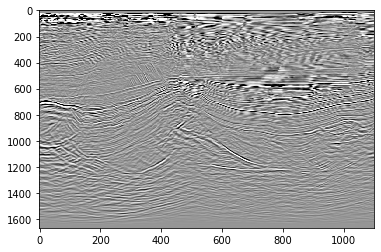

In [135]:
plt.imshow(fig1[:, :], cmap="Greys", vmin=-vm, vmax=vm, aspect='auto') # In grey scale

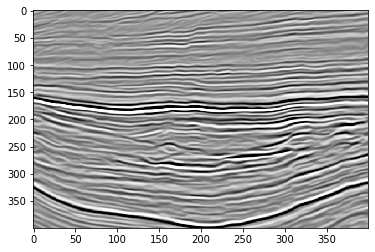

In [115]:
plt.imshow(fig1[400:800, 600:1000], cmap="Greys", vmin=-vm, vmax=vm, aspect='auto') # Select a part of the original image

Read the class label map and transpose it.

In [126]:
stream1 = _read_segy('/home/chen/Downloads/Data_1106/Inline_3223_class.sgy', headonly=True)
stream1
figc = []
for i in range(len(stream1.traces)):
    figc.append(stream1.traces[i].data)
figc = np.array(figc)
figc = figc.T
print(figc.shape)

(1667, 1101)


The 99th percentile is 7; the max amplitude is 7


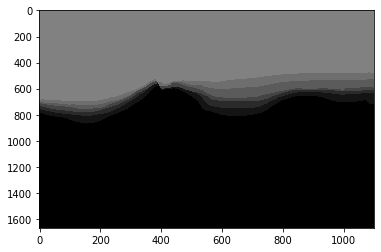

In [128]:
vm1 = np.percentile(figc, 100)
print("The 99th percentile is {:.0f}; the max amplitude is {:.0f}".format(vm1, figc.max()))
plt.imshow(figc, cmap="Greys", vmin=-vm1, vmax=vm1, aspect='auto')

The 99th percentile is 10418; the max amplitude is 35164


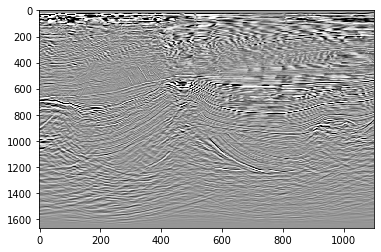

In [10]:
vm1 = np.percentile(figt[1], 99)
print("The 99th percentile is {:.0f}; the max amplitude is {:.0f}".format(vm1, figt[1].max()))
plt.imshow(figt[1], cmap="Greys", vmin=-vm1, vmax=vm1, aspect='auto')

Read all inline data and save them.

In [6]:
stream1 = _read_segy('/home/chen/Downloads/Data_1106/Inline_3223_DSMF_2.sgy', headonly=True)
stream2 = _read_segy('/home/chen/Downloads/Data_1106/Inline_3373_DSMF_2.sgy', headonly=True)
stream3 = _read_segy('/home/chen/Downloads/Data_1106/Inline_3473_DSMF_2.sgy', headonly=True)
streams = [stream1, stream2, stream3]
fig = []

for stream in streams:
    figtemp = []
    for i in range(len(stream.traces)):
        figtemp.append(stream.traces[i].data)    
    figtemp = np.array(figtemp)
    figtemp = figtemp.T
    fig.append(figtemp)
fig = np.array(fig)
print(fig.shape)

(3, 1667, 1101)


In [7]:
stream4 = _read_segy('/home/chen/Downloads/Data_1106/Inline_3292_DSMF_ref.sgy', headonly=True)
stream5 = _read_segy('/home/chen/Downloads/Data_1106/Inline_3424_DSMF_ref.sgy', headonly=True)
streamst = [stream4, stream5]
figt = []

for stream in streamst:
    figtemp = []
    for i in range(len(stream.traces)):
        figtemp.append(stream.traces[i].data)    
    figtemp = np.array(figtemp)
    figtemp = figtemp.T
    figt.append(figtemp)
figt = np.array(figt)
print(figt.shape)

(2, 1667, 1101)


Read all class label map for inline data and save them.

In [8]:
streamc1 = _read_segy('/home/chen/Downloads/Data_1106/Inline_3223_class.sgy', headonly=True)
streamc2 = _read_segy('/home/chen/Downloads/Data_1106/Inline_3373_class.sgy', headonly=True)
streamc3 = _read_segy('/home/chen/Downloads/Data_1106/Inline_3473_class.sgy', headonly=True)
streamcs = [streamc1, streamc2, streamc3]
figc = []

for streamc in streamcs:
    figctemp = []
    for i in range(len(streamc1.traces)):
        figctemp.append(streamc1.traces[i].data)    
    figctemp = np.array(figctemp)
    figctemp = figctemp.T
    figc.append(figctemp)
figc = np.array(figc)
print(figc.shape)

(3, 1667, 1101)


An example of what class label map looks like in python.

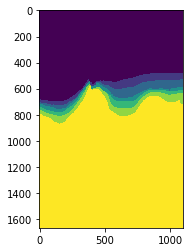

In [7]:
plt.imshow(figc[2])

### 2.2 Pad the data

Define the size for a mini_batch (Cube size is just a half of the mini_batch size - 1, only helps for calculation).

In [7]:
minib_size = 65
cube_size = 32

Write a function for padding of one inline/crossline slice.

In [8]:
def pad_data(fig, minib_size):
    '''
    fig - the original seismic image, should be a 2D array.
    minib_size - size of the mini batch for each training object.
    '''
    pad_size = minib_size//2

    xconcatb = []
    xconcatm = []

    
    for i in range(pad_size):
        xconcatbtemp = []
        for j in range(2*pad_size + fig.shape[1]):
            xconcatbtemp.append(0.)
        xconcatb.append(xconcatbtemp)    
    
    for i in range(len(fig)):
        xconcatmtemp = []
        for j in range(pad_size):
            xconcatmtemp.append(0.)
        xconcatm.append(xconcatmtemp)
    xconcatm = np.array(xconcatm)

        
    fig = np.concatenate((xconcatm, fig), axis = 1)
    fig = np.concatenate((fig, xconcatm), axis = 1)        
    
    fig = np.concatenate((xconcatb, fig), axis = 0)
    fig = np.concatenate((fig, xconcatb), axis = 0)    
    
    return np.array(fig)

a = pad_data(fig[1], minib_size)

Pad each slice and store them together again.

In [9]:
fignew = []
for i in range(len(fig)):
    fignew.append(pad_data(fig[i], minib_size))
fig = np.array(fignew)
print(fig.shape) # Check the dimensions

(3, 1731, 1165)


In [38]:
fignew = []
for i in range(len(figt)):
    fignew.append(pad_data(figt[i], minib_size))
figt = np.array(fignew)
print(figt.shape) # Check the dimensions

(2, 1731, 1165)


### 2.3 Balance the data

Sort the training objects by their class labels.

In [13]:
clss = np.unique(figc) 
sep_indices = []

for n in range(len(clss)):
    sep_indices.append([])
    
for n in range(len(clss)):
    for i in range(fig.shape[0]):
        for j in range(cube_size, fig.shape[1] - cube_size):
            for k in range(cube_size, fig.shape[2] - cube_size):               
                if int(figc[i, j-cube_size, k-cube_size]) == n+1:
                    sep_indices[n].append([i , j , k])

print(len(sep_indices))

7


Write a function to balance the data.

In [14]:
def data_balancing(sep_indices, num):
    '''
    sep_indices - sorted coordinates by class label.
    num - number of training objects for each class we would like after banlancing.
    '''
    
    for indices in sep_indices:
        n = np.random.randint(0.98 * num, 1.02 * num)
        while len(indices) < n:
            indices.append(indices[np.random.randint(0, len(indices))])
        
        while len(indices) > n: 
            del(indices[np.random.randint(0, len(indices))])  
        
    final_indices = []
    final_labels = []
    
    for i in range(len(sep_indices)):
        for j in range(len(sep_indices[i])):
            final_indices.append(sep_indices[i][j])
            final_labels.append(i)
            
    return np.array(final_indices), np.array(final_labels)

d, j = data_balancing(sep_indices,150000)
print(d.shape)
print(j.shape)

(1060382, 3)
(1060382,)


This process may cost some time so we can save the balanced data and just load the data next time.

In [254]:
np.save('indices1306', d)
np.save('labels1306', j)

In [10]:
X_train = np.load('indices1306.npy')
y_train = np.load('labels1306.npy')
print(y_train.shape)

(1050030,)


In [11]:
def separate_train_val(X_train, y_train, ratio):
    '''Ill-Designed, Wrong, Should intiate differently beforehand, Only use it to test'''
    image = []
    for item in X_train:
        image.append(item[0])
    image = np.array(image)
    image = np.unique(image)
    nimage = len(image)
    nsplit = round(ratio * nimage)
    random_index = []
    for i in range(nsplit):
        n = np.random.randint(0, len(image))
        random_index.append(n)
        image = np.delete(image, n)
    print(random_index)    
    X_val = []
    y_val = []
    X_train_f = []
    y_train_f = []
    
    for i in range(len(X_train)):
        if X_train[i][0] in random_index:
            X_val.append(X_train[i])
            y_val.append(y_train[i])
        else:
            X_train_f.append(X_train[i])
            y_train_f.append(y_train[i])
    
    X_val, y_val = np.array(X_val), np.array(y_val)
    X_train, y_train = np.array(X_train_f), np.array(y_train_f)        
    
    return X_train, y_train, X_val, y_val
    

Do not use it to separate the training and validation set.

In [12]:
X_train, y_train, X_val, y_val = separate_train_val(X_train, y_train, 0.4)
print(X_train.shape)
print(y_train.shape)

[1]
(700640, 3)
(700640,)


### 2.4 Transform and load the data

Transform the labels array to a Pytorch Tensor.

In [13]:
y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)

We need to normalize the databefore training. This should happen after padding.

In [14]:
def normalisation(figs):
    figs = figs.float()
    mean = torch.mean(figs)
    std = torch.std(figs)
    figs -= mean
    figs /= std
    print(mean)
    print(std)
    return figs

In [15]:
seismic = torch.FloatTensor(fig)
seismic = normalisation(seismic)

tensor(15.7457)
tensor(3491.4585)


Use custom Datasets to save the data.

In [16]:
class MalenovDataset(Dataset):
    def __init__(self, seismic, indices, labels, cube_size):
        self.seismic = seismic
        self.cube_size = cube_size
        self.indices = indices
        self.labels = labels
        self.count = len(self.labels)
    

    def __getitem__(self, index):
        idx = self.indices[index]
        img = self.seismic[idx[0],
                           idx[1]-self.cube_size:idx[1]+self.cube_size+1,
                           idx[2]-self.cube_size:idx[2]+self.cube_size+1]
        label = self.labels[index]
        return (img, label)

 

    def __len__(self):
        return self.count # of how many examples(images?) you have


class MalenovTestDataset(Dataset):
    def __init__(self, seismic, inline, cube_size):
        self.seismic = seismic
        self.cube_size = cube_size
        self.indices = []
        self.amplitudes = []

        for i in range(self.seismic.shape[2]):
            for j in range(self.seismic.shape[3]):
                if cube_size <= i < seismic.shape[2]-cube_size and cube_size <= j < seismic.shape[3]-cube_size:
                    idx = [inline, i, j]
                    self.indices.append(idx)
                    self.amplitudes.append(self.seismic[:, idx[0], idx[1], idx[2]])
        self.count = len(self.indices)      

    def __getitem__(self, index):
        idx = self.indices[index]
        img = self.seismic[:, idx[0]-self.cube_size:idx[0]+self.cube_size+1,
                            idx[1]-self.cube_size:idx[1]+self.cube_size+1,
                            idx[2]-self.cube_size:idx[2]+self.cube_size+1]
        return img
 

    def __len__(self):
        return self.count # of how many examples(images?) you have

In [17]:
class ChenDataset_original(Dataset):
    def __init__(self, seismic, indices, labels, cube_size, prior_transform = None):
        self.seismic = seismic
        self.cube_size = cube_size
        self.indices = indices
        self.labels = labels
        self.count = len(self.labels)
        self.prior_transform = prior_transform
        self.visit = np.zeros_like(seismic)
    

    def __getitem__(self, index):
        idx = self.indices[index]
        img = self.seismic[idx[0],
                           idx[1]-self.cube_size:idx[1]+self.cube_size+1,
                           idx[2]-self.cube_size:idx[2]+self.cube_size+1]

        if self.visit[idx[0], idx[1], idx[2]] == 0:            
            self.visit[idx[0], idx[1], idx[2]] = 1
        elif self.visit[idx[0], idx[1], idx[2]] == 1:
            img = self.prior_transform(img)[0]
        label = self.labels[index]
        return (img, label)

 

    def __len__(self):
        return self.count # of how many examples(images?) you have
    
    
class ChenDataset_dynamic(Dataset):
    def __init__(self, seismic, indices, labels, cube_size, dynamic_transform = None):
        self.seismic = seismic
        self.cube_size = cube_size
        self.indices = indices
        self.labels = labels
        self.count = len(self.labels)
        self.dynamic_transform = dynamic_transform
    

    def __getitem__(self, index):
        idx = self.indices[index]
        if self.dynamic_transform:
            img = self.dynamic_transform(self.seismic[idx[0],
                               idx[1]-self.cube_size:idx[1]+self.cube_size+1,
                               idx[2]-self.cube_size:idx[2]+self.cube_size+1]) 
            if img.shape[0] == 1:
                img = img[0]
            
        label = self.labels[index]
        
        return (img, label)

 

    def __len__(self):
        return self.count # of how many examples(images?) you have
    
# Define the transformations
prior_train_transform = transforms.Compose([transforms.ToPILImage(),
                 transforms.RandomAffine(degrees = 15, translate = (0.05, 0.05)),
                 transforms.ToTensor()])
    
transformtype = [transforms.ToPILImage(),
                 transforms.RandomAffine(degrees = 15, translate = (0.05, 0.05)),
                 transforms.ToTensor()]

dynamic_train_transform = transforms.RandomApply(transformtype, p = 0.2)

make train and validation datasets

In [18]:
train_dset = ChenDataset_original(seismic, X_train, y_train, cube_size, prior_train_transform)
val_dset = MalenovDataset(seismic, X_val, y_val, cube_size)

Just create a Test set from Training, Ill-designed

In [20]:
indices = []
labels = []

for j in range(cube_size, fig.shape[1] - cube_size):
    for k in range(cube_size, fig.shape[2] - cube_size):
        indice = [2 , j , k]
        label = figc[2, j-cube_size, k-cube_size]
        indices.append(indice)
        labels.append(label)
indices = np.array(indices)
labels = np.array(labels)
print(indices.shape)
print(labels.shape)

(1835367, 3)
(1835367,)


In [21]:
for i in range(len(labels)):
    labels[i] -= 1

In [22]:
print(labels)

[ 0.  0.  0. ...,  6.  6.  6.]


In [39]:
seismic1 = torch.FloatTensor(figt)
seismic1 = normalisation(seismic1)

tensor(9.5525)
tensor(2418.4050)


In [47]:
indices = []
labels = []

for j in range(cube_size, fig.shape[1] - cube_size):
    for k in range(cube_size, fig.shape[2] - cube_size):
        indice = [1 , j , k]
        indices.append(indice)
        labels.append(0)
indices = np.array(indices)
labels = np.array(labels)
print(indices.shape)
print(labels.shape)

(1835367, 3)
(1835367,)


In [48]:
X_test = indices
y_test = labels
test_dset = MalenovDataset(seismic1, X_test, y_test, cube_size)
test_loader = DataLoader(test_dset, shuffle = False, batch_size = (figt.shape[2] - 2 * cube_size), num_workers = 4)

In [34]:
X_test = indices
y_test = labels
test_dset = MalenovDataset(seismic, X_test, y_test, cube_size)
test_loader = DataLoader(test_dset, shuffle = False, batch_size = (figt.shape[2] - 2 * cube_size), num_workers = 4)

Load the train and validation dataset to Dataloader.

In [19]:
train_loader = DataLoader(train_dset, shuffle = True, batch_size = 128, num_workers = 0)
val_loader = DataLoader(val_dset, shuffle = False, batch_size = 128, num_workers = 0)

## 3. CNN Model

### 3.1 Create a CNN.

I tried to use other complex networks but none of them works because of the CPU stuff. Will Try it next week.

In [57]:
import torchvision.models as models
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    model.fc = nn.Linear(512*4, 7)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/chen/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [04:34<00:00, 373064.90it/s]


In [26]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=7, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        

        return x

In [27]:
class MalenovNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 50, kernel_size=5, stride=4, padding=2)
        self.bn1 = nn.BatchNorm2d(50)
        
        self.conv2 = nn.Conv2d(50, 50, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(50)        
        self.drop2 = nn.Dropout2d(0.2)
        
        self.conv3 = nn.Conv2d(50, 50, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(50)  
        self.drop3 = nn.Dropout2d(0.2)
            
        self.conv4 = nn.Conv2d(50, 50, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(50)          
        self.drop4 = nn.Dropout2d(0.2)
        
        self.conv5 = nn.Conv2d(50, 50, kernel_size=3, stride=2, padding=1)  
        
        self.linear1 = nn.Linear(200, 50)
        self.bn_ln1 = nn.BatchNorm1d(50)
        self.linear2 = nn.Linear(50, 10)
        self.bn_ln2 = nn.BatchNorm1d(10)
        
        self.logits = nn.Linear(10, 7)
        self.bn_logits = nn.BatchNorm1d(7)
        
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.drop2(self.conv2(x))))
        x = F.relu(self.bn3(self.drop3(self.conv3(x))))   
        x = F.relu(self.bn4(self.drop4(self.conv4(x)))) 
        x = self.conv5(x)
        x = x.view(-1, 200)
        x = F.relu(self.bn_ln1(self.linear1(x)))
        x = F.relu(self.bn_ln2(self.linear2(x)))
        logits = self.bn_logits(self.logits(x))
        return logits

In [20]:
class MalenovNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1) # Convolution 1, adapted to 28x28 single channel
        self.bn1 = nn.BatchNorm2d(64) #Batch Norm 1

        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=3) # Convolution 2
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2) #MaxPool 2
        self.bn2 = nn.BatchNorm2d(128) # Batch Norm 2
              
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1) # NEW Convolution 6
        self.bn3 = nn.BatchNorm2d(128) #Batch Norm 6
        self.conv4 = nn.Conv2d(128, 64, kernel_size=5, stride=3, padding=1) # NEW Convolution 7
        self.bn4 = nn.BatchNorm2d(64) # Batch Norm 7

        self.fc5 = nn.Linear(64*3*3, 288) # Fully Connected Layer 1
        self.bn5 = nn.BatchNorm1d(288) #Batch Norm 8
        self.fc6 = nn.Linear(288, 100) # Fully Connected Layer 3
        self.bn6 = nn.BatchNorm1d(100) # Batch Norm 9
        self.fc7 = nn.Linear(100, 7) #Final Linear Layer

        self.bn_logits = nn.BatchNorm1d(7)
        
        self.drop = nn.Dropout2d(0.2)
        
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.pool2(self.conv2(x))))
        x = F.relu(self.bn3(self.drop(self.conv3(x))))   
        x = F.relu(self.bn4(self.drop(self.conv4(x)))) 

        x = x.view(-1, 64*9)
        x = F.relu(self.bn5(self.fc5(x)))
        x = F.relu(self.bn6(self.fc6(x)))
        logits = self.bn_logits(self.fc7(x))
        return logits

### 3.2 Train the model

Define some hyperparameters

In [23]:
lr = 2e-2
mom = 0.05
batch_size = 128
test_batch_size = (fig.shape[2] - 2 * cube_size)
n_epochs = 10
w_decay = 0.0

Define the train and validation functions for CNN.

In [22]:
def train(model, optimizer, criterion, data_loader, minib_size):
    model.train() # train model mode
    train_loss, train_accuracy = 0, 0 #instantiate return variables
    for X, y in data_loader: #iterate over data in batch size
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad() #reset optimizer gradients
        a2 = model(X.view(X.size(0), 1, minib_size, minib_size)).to(device) # predict for current data the model(x) value
        loss = criterion(a2, y.long()) #compute the loss by computing the criterion(y_prediction, y_real)
        loss.backward()  #perform backpropagation
        train_loss += loss*X.size(0) # keep track of loss
        y_pred = F.log_softmax(a2, dim=1).max(1)[1] # apply softmax layer to prediction
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0) # check for accuracy
        optimizer.step()  # step on gradient descent 
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader, minib_size):
    model.eval() #model evaluation
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad(): # no optimisierr or stepping
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(X.size(0), 1, minib_size, minib_size)).to(device) # predict for current data the model(x) value
            loss = criterion(a2, y.long()) #compute the loss by computing the criterion(y_prediction, y_real)
            validation_loss += loss*X.size(0)# keep track of loss
            y_pred = F.log_softmax(a2, dim=1).max(1)[1] # apply softmax layer to prediction
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0) # check and track accuracy
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)


Initiate the model and define loss criterion and optimizer.

In [24]:
model = MalenovNet()#ResNet(BasicBlock, [2, 2, 2, 2])
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas = (0.9, 0.999), eps = 1e-08, weight_decay = w_decay)

Dynamic training with validation.

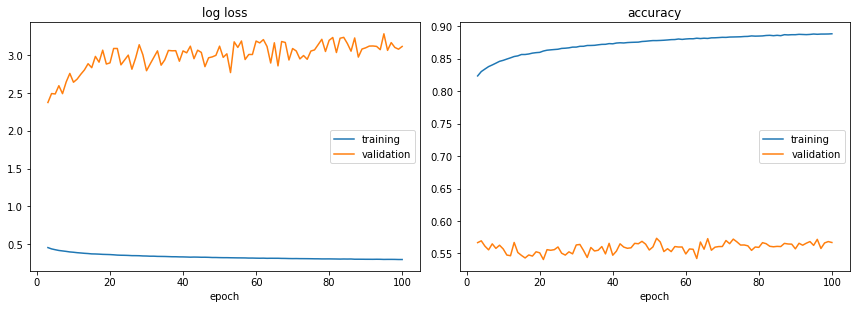

log loss:
training   (min:    0.295, max:    0.473, cur:    0.295)
validation (min:    2.375, max:    3.284, cur:    3.117)

accuracy:
training   (min:    0.816, max:    0.888, cur:    0.888)
validation (min:    0.540, max:    0.573, cur:    0.567)


In [176]:
liveloss = PlotLosses()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.95, patience = 8)
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader, minib_size)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    
    validation_loss, validation_accuracy = validate(model, criterion, val_loader, minib_size) # validate model using validation data loader
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()
    
    scheduler.step(validation_loss.item())
    
    train_dset = ChenDataset_dynamic(seismic, X_train, y_train, cube_size, dynamic_train_transform)
    train_loader = DataLoader(train_dset, shuffle = True, batch_size = 128, num_workers = 8)

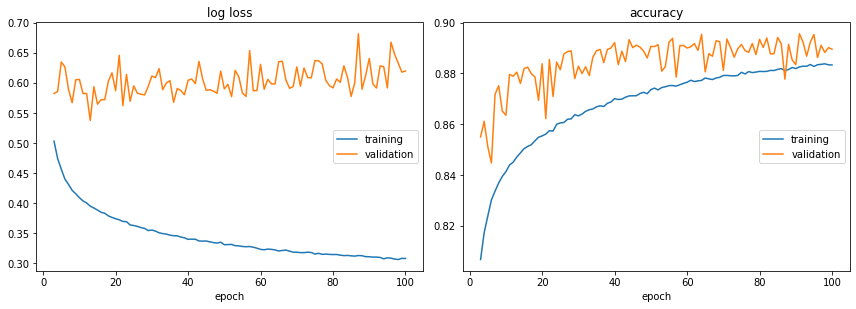

log loss:
training   (min:    0.306, max:    0.692, cur:    0.308)
validation (min:    0.537, max:    0.682, cur:    0.620)

accuracy:
training   (min:    0.738, max:    0.884, cur:    0.883)
validation (min:    0.828, max:    0.896, cur:    0.890)


In [28]:
liveloss = PlotLosses()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.95, patience = 8)
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader, minib_size)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    
    validation_loss, validation_accuracy = validate(model, criterion, val_loader, minib_size) # validate model using validation data loader
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()
    
    scheduler.step(validation_loss.item())
    
    del train_dset
    del train_loader
    
    train_dset = ChenDataset_dynamic(seismic, X_train, y_train, cube_size, dynamic_train_transform)
    train_loader = DataLoader(train_dset, shuffle = True, batch_size = 128, num_workers = 4)

In [ ]:
liveloss = PlotLosses()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.95, patience = 8)
for epoch in range(10):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader, minib_size)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    
    validation_loss, validation_accuracy = validate(model, criterion, val_loader, minib_size) # validate model using validation data loader
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()
    
    scheduler.step(validation_loss.item())
    
    del train_dset
    del train_loader
    
    train_dset = ChenDataset_dynamic(seismic, X_train, y_train, cube_size, dynamic_train_transform)
    train_loader = DataLoader(train_dset, shuffle = True, batch_size = 128, num_workers = 0)

In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1) # Convolution 1, adapted to 28x28 single channel
        self.batchnorm1 = nn.BatchNorm2d(64) #Batch Norm 1

        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, stride=2, padding=3) # Convolution 2
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2) #MaxPool 2
        self.batchnorm2 = nn.BatchNorm2d(192) # Batch Norm 2
              
        self.conv3 = nn.Conv2d(192, 128, kernel_size=3, stride=2, padding=1) # NEW Convolution 6
        self.batchnorm3 = nn.BatchNorm2d(128) #Batch Norm 6
        self.conv4 = nn.Conv2d(128, 64, kernel_size=5, stride=3, padding=1) # NEW Convolution 7
        self.batchnorm4 = nn.BatchNorm2d(64) # Batch Norm 7

        self.fc5 = nn.Linear(64*3*3, 288) # Fully Connected Layer 1
        self.batchnorm5 = nn.BatchNorm1d(288) #Batch Norm 8
        self.fc6 = nn.Linear(288, 100) # Fully Connected Layer 3
        self.batchnorm6 = nn.BatchNorm1d(100) # Batch Norm 9
        self.fc7 = nn.Linear(100, 7) #Final Linear Layer
        
        self.dropout = nn.Dropout() # Dropout at last Fully Connected Layer
        
        self.activation = nn.ReLU() # ReLU activation after each active layer

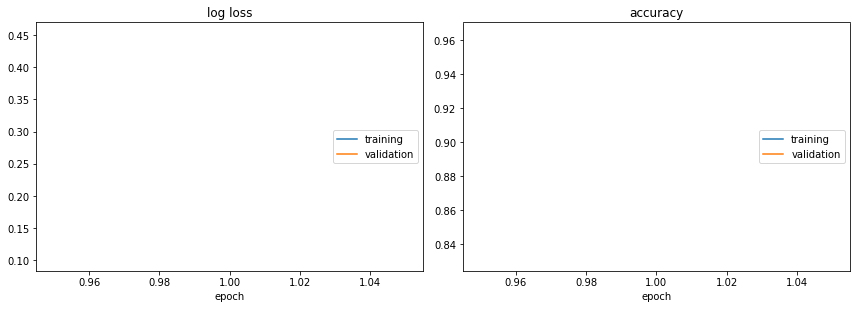

log loss:
training   (min:    0.452, max:    0.452, cur:    0.452)
validation (min:    0.101, max:    0.101, cur:    0.101)

accuracy:
training   (min:    0.831, max:    0.831, cur:    0.831)
validation (min:    0.964, max:    0.964, cur:    0.964)


KeyboardInterrupt: 

In [31]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=2, padding=3)
        self.bn2 = nn.BatchNorm2d(64) 
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2) #MaxPool 2
        self.drop2 = nn.Dropout2d(0.2)
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, stride=4)
        self.bn3 = nn.BatchNorm2d(64)  
        self.drop3 = nn.Dropout2d(0.2)
            
        self.fc5 = nn.Linear(64*4*4, 388) # Fully Connected Layer 1
        self.batchnorm5 = nn.BatchNorm1d(388) #Batch Norm 8
        self.fc6 = nn.Linear(388, 100) # Fully Connected Layer 3
        self.batchnorm6 = nn.BatchNorm1d(100) # Batch Norm 9
        self.fc7 = nn.Linear(100, 7) #Final Linear Layer
        self.bn_logits = nn.BatchNorm1d(7)
        
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.drop2(self.pool1(self.conv2(x)))))
        x = F.relu(self.bn3(self.drop3(self.conv3(x))))   

        x = x.view(-1, 64*4*4)
        x = F.relu(self.batchnorm5(self.fc5(x)))
        x = F.relu(self.batchnorm6(self.fc6(x)))
        logits = self.bn_logits(self.fc7(x))
        return logits
    
model = AlexNet()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas = (0.9, 0.999), eps = 1e-08, weight_decay = w_decay)
liveloss = PlotLosses()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.95, patience = 8)
for epoch in range(10):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader, minib_size)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    
    validation_loss, validation_accuracy = validate(model, criterion, val_loader, minib_size) # validate model using validation data loader
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()
    
    scheduler.step(validation_loss.item())
    
    del train_dset
    del train_loader
    
    train_dset = ChenDataset_dynamic(seismic, X_train, y_train, cube_size, dynamic_train_transform)
    train_loader = DataLoader(train_dset, shuffle = True, batch_size = 128, num_workers = 4)

Dynamic full dataset training.

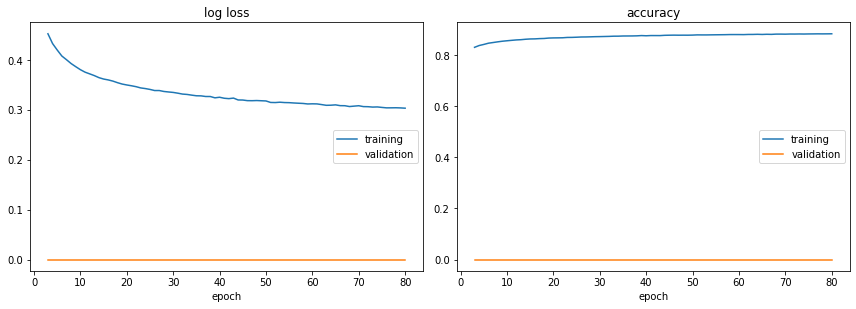

log loss:
training   (min:    0.303, max:    0.593, cur:    0.303)
validation (min:    0.000, max:    0.000, cur:    0.000)

accuracy:
training   (min:    0.779, max:    0.885, cur:    0.885)
validation (min:    0.000, max:    0.000, cur:    0.000)


In [84]:
liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader, minib_size)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.
    liveloss.update(logs)
    liveloss.draw()
    
    train_dset = ChenDataset_dynamic(seismic, X_train, y_train, cube_size, dynamic_train_transform)
    train_loader = DataLoader(train_dset, shuffle = True, batch_size = 32, num_workers = 4)

Save the model parameters.

In [29]:
model_save_name = '11secondtry.pt'
path = F'/home/chen/Downloads/{model_save_name}'
torch.save(model.state_dict(), path)

Load the model.

In [52]:
model = MalenovNet()
model_save_name = 'secondtry.pt'
path = F'/home/chen/Downloads/{model_save_name}'
model.load_state_dict(torch.load(path))
model.eval()

MalenovNet(
  (conv1): Conv2d(1, 50, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
  (bn1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(50, 50, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout2d(p=0.2)
  (conv3): Conv2d(50, 50, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop3): Dropout2d(p=0.2)
  (conv4): Conv2d(50, 50, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop4): Dropout2d(p=0.2)
  (conv5): Conv2d(50, 50, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (linear1): Linear(in_features=200, out_features=50, bias=True)
  (bn_ln1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (line

Write a function to evaluate the model.

In [ ]:
def evaluate(model, data_loader, minib_size):
  # function to evaluate the predictions given a dataset
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader: # iterate over test data
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(X.size(0), 1, minib_size, minib_size)).to(device) #predict
            y_pred = F.log_softmax(a2, dim=1).max(1)[1] #apply softamx activation
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy()) # keep track of predicted class
            
    return np.concatenate(y_preds, 0), np.concatenate(ys, 0)

y_pred, y_gt = evaluate(model, val_loader, minib_size)

Show the confusion Matrix

In [26]:
cm = ConfusionMatrix(actual_vector = y_gt, predict_vector = y_pred)
print(cm)

Predict     0           1           2           3           4           5           6           
Actual
0           50069       923         7           16          23          19          40          

1           36          49679       147         18          0           11          0           

2           0           349         49547       649         0           0           0           

3           2           107         119         48746       447         17          0           

4           2           3           0           373         50159       161         0           

5           3           6           0           119         699         48330       83          

6           43          46          12          22          63          918         47843       





Overall Statistics : 

95% CI                                                            (0.98392,0.98474)
ACC Macro                                                         0.99552
AUNP                     

The function to evaluate and make an array with the same dimensions as the original class label map.

In [53]:
def evaluate_and_layout(model, data_loader, minib_size):
  # function to evaluate the predictions given a dataset
    model.eval()
    y_preds = []
    for X, y in data_loader: # iterate over test data
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(X.size(0), 1, minib_size, minib_size)).to(device) #predict
            y_pred = F.log_softmax(a2, dim=1).max(1)[1] #apply softamx activation
            y_preds.append(y_pred.cpu().numpy()) # keep track of predicted class
    return np.array(y_preds)

pred_image = evaluate_and_layout(model, test_loader, minib_size)

Check the shape.

In [54]:
print(pred_image.shape)

(1667, 1101)


Show the result.

Results for the 3rd slice with the model trained by the first two slices.

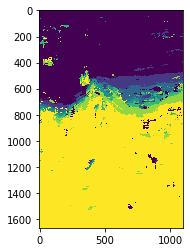

In [32]:
plt.imshow(pred_image)

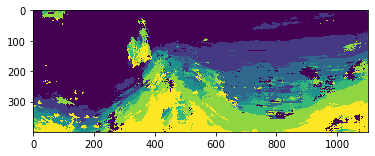

In [34]:
plt.imshow(pred_image[400:800,:])

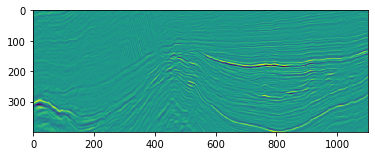

In [13]:
plt.imshow(fig[2][400:800,:])

Results for the 5th slice with the model trained by the first two slices.

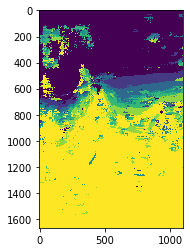

In [51]:
plt.imshow(pred_image)

Results for the 5th slice with the model trained by the first two slices.

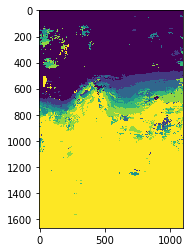

In [55]:
plt.imshow(pred_image)

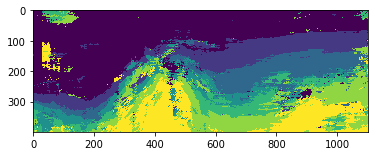

In [56]:
plt.imshow(pred_image[400:800,:])

Original image for the 5th slice.

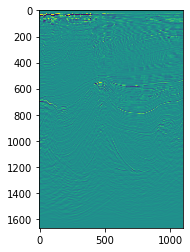

In [17]:
plt.imshow(figt[1])

The 99th percentile is 10418; the max amplitude is 35164


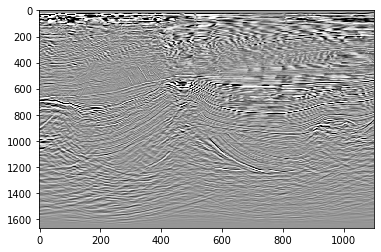

In [16]:
vm1 = np.percentile(figt[1], 99)
print("The 99th percentile is {:.0f}; the max amplitude is {:.0f}".format(vm1, figt[1].max()))
plt.imshow(figt[1], cmap="Greys", vmin=-vm1, vmax=vm1, aspect='auto')

## 4. Feed - Forward Neural Network model

### 4.1 Create a FNN

In [148]:
class LegacyNet(nn.Module):
    def __init__(self, minib_size):
        super(LegacyNet, self).__init__()
        self.linear1 = nn.Linear(minib_size * minib_size, 1000)
        self.linear2 = nn.Linear(1000, 50)
        self.linear3 = nn.Linear(50, 7)
        self.batchnorm1 = nn.BatchNorm1d(1000)
        self.batchnorm2 = nn.BatchNorm1d(50)
        self.batchnorm3 = nn.BatchNorm1d(7)
        self.a = nn.ReLU()
        
    def forward(self, x):
        z1 = self.linear1(x)
        a1 = self.a(self.batchnorm1(z1))
        z2 = self.linear2(a1)
        a2 = self.batchnorm2(z2)
        z3 = self.linear3(a2)
        a3 = self.batchnorm3(z3)
        return a3

Load the data.

In [149]:
train_dset = ChenDataset_original(seismic, X_train, y_train, cube_size, prior_train_transform)
#val_dset = MalenovDataset(seismic, X_val, y_val, cube_size)
train_loader = DataLoader(train_dset, shuffle = True, batch_size = 32, num_workers = 8)

### 4.2 Train the model

In [150]:
def train(model, optimizer, criterion, data_loader, minib_size):
    model.train() # train model mode
    train_loss, train_accuracy = 0, 0 #instantiate return variables
    for X, y in data_loader: #iterate over data in batch size
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad() #reset optimizer gradients
        a2 = model(X.view(-1, minib_size * minib_size)).to(device) # predict for current data the model(x) value
        loss = criterion(a2, y.long()) #compute the loss by computing the criterion(y_prediction, y_real)
        loss.backward()  #perform backpropagation
        train_loss += loss*X.size(0) # keep track of loss
        y_pred = F.log_softmax(a2, dim=1).max(1)[1] # apply softmax layer to prediction
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0) # check for accuracy
        optimizer.step()  # step on gradient descent 
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)

Initiate the model and define loss criterion and optimizer.

In [151]:
model = LegacyNet(minib_size)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas = (0.9, 0.999), eps = 1e-08, weight_decay = w_decay)

Normal training without dynamic data augmentation.

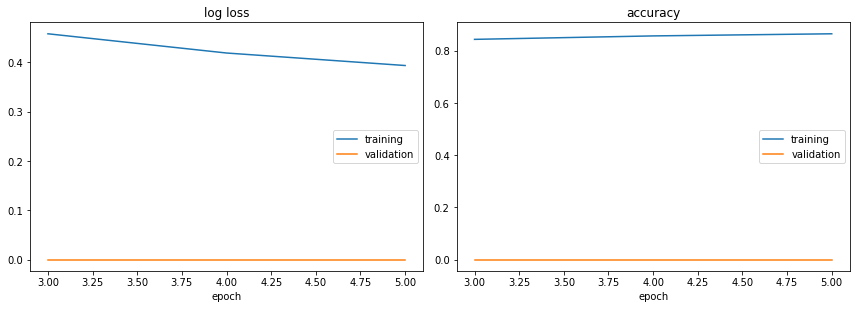

log loss:
training   (min:    0.394, max:    0.857, cur:    0.394)
validation (min:    0.000, max:    0.000, cur:    0.000)

accuracy:
training   (min:    0.698, max:    0.865, cur:    0.865)
validation (min:    0.000, max:    0.000, cur:    0.000)


Traceback (most recent call last):
  File "/home/chen/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/chen/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/chen/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/chen/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/chen/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/chen/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/chen/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + 

KeyboardInterrupt: 

In [152]:
liveloss = PlotLosses()
acculi = []
for epoch in range(30):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader, minib_size)
    acculi.append(train_accuracy.item())
    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.
    liveloss.update(logs)
    liveloss.draw()

## Part 2. Variogram for Gamma Ray

Read the data.

In [ ]:
import xlrd

In [ ]:
data1 = xlrd.open_workbook('Gabon_Offshore_GR_regional_ML.xlsx')

In [ ]:
sheetname = 'Gabon_Offshore_GR_regional_ML'
table = data1.sheet_by_name(sheetname)
nrows = table.nrows
ncols = table.ncols
Well = []
Depth = []
GR = []

for i in range(1,nrows):
    rowV = table.row_values(i)
    Well.append(rowV[0])
    Depth.append(rowV[1])
    GR.append(rowV[2])

print(len(Well))
print(len(Depth))
print(len(GR))


Make a lag list.

In [ ]:
laglist = [0]
lag = 0.1524
lagnew = lag
while lagnew < 10:
    laglist.append(lagnew)
    lagnew += lag
laglist.append(10)
print(laglist)

Classify the data by well.

In [ ]:
cGR = []
cDep = []
well = ''
for i in range(len(Depth)):
    if Well[i] != well:
        well = Well[i]
        if i != 0:
            cGR.append(dGRtemp)
            dGRtemp = [GR[i]]
            cDep.append(dDeptemp)
            dDeptemp = [Depth[i]]
        else:
            dGRtemp = [GR[i]]
            dDeptemp = [Depth[i]]
    else:
        dGRtemp.append(GR[i])
        dDeptemp.append(Depth[i])

Compute the variogram.

In [ ]:
def calc_dhdyn(GR, Dep, laglist):
    varl = []
    mlist = []

    for k in range(len(laglist)-1):
        disl = laglist[k]
        dish = laglist[k+1]
        var = 0
        m = 0
        for i in range(len(GR)-1):
            for j in range(i, len(GR)):
                if dish > Dep[j] - Dep[i] and disl <= Dep[j] - Dep[i]:
                    m += 1
                    var += ((GR[j] - GR[i])**2)
                elif dish <= Dep[j] - Dep[i]:
                    break   
        if m > 0:
            varl.append(var/(2*m))
        else:
            varl.append(0)
        mlist.append(m)
    return mlist, varl

In [ ]:
a, b= calc_dhdyn(cGR[0],cDep[0], laglist)

In [ ]:
bigvar = []
for i in range(len(cGR)):
    a, b = calc_dhdyn(cGR[i], cDep[i], laglist)
    bigvar.append(b)
print(len(bigvar))
print(len(bigvar[0]))

Plot the variograms.

In [ ]:
plotlag = []
for i in range(len(laglist)-1):
    plotlag.append(laglist[i] + ((laglist[i+1]-laglist[i])/2))

for i in range(len(bigvar)):
    plt.plot(plotlag,bigvar[i])

In [ ]:
plt.plot(plotlag,bigvar[8])